In [1]:
import numpy as np
from numba import njit
import pandas as pd

In [2]:
@njit(fastmath=True)
def scan_qty(lon_c_arr, lat_c_arr, qty_arr, 
             lon, lat, qty, cone_size, lon_step, lat_step, cos_weight=True,
             ):
    # unit conversions
    theta = cone_size # set alias
    theta_rad = theta * np.pi / 180
    lat_rad = lat * np.pi / 180 # the memory load is not very high so we can do this
    lon_rad = lon * np.pi / 180

    n_tot = len(lon)

    for lon_c in range(-180, 180):

        if lon_c % lon_step != 0: # numba parallel only supports step size of 1
            continue
        lon_c_rad = lon_c * np.pi / 180

        for lat_c in range(-90, 90):

            if lat_c % lat_step != 0: # if you are wondering, 0 % lat_step = 0
                continue
            lat_c_rad = lat_c * np.pi / 180

            a = np.pi / 2 - lat_c_rad # center of cone to zenith
            b = np.pi / 2 - lat_rad   # cluster to zenith
            costheta = np.cos(a)*np.cos(b) + np.sin(a)*np.sin(b)*np.cos(lon_rad - lon_c_rad) # cosθ=cosa*cosb+sina*sinb*cosA
            mask = costheta > np.cos(theta_rad)
            n_clusters = np.sum(mask)

            # Mask selection
            cone_qty = qty[mask]

            # Indexing
            idx = (lon_c+180)//lon_step * 180//lat_step + (lat_c+90)//lat_step

            # If no cluster in the cone
            if np.sum(cone_qty) == 0:
                lon_c_arr[idx] = lon_c
                lat_c_arr[idx] = lat_c
                qty_arr[idx]   = 0
                continue

            # Inverse cosine weighting to emphasize the direction
            if cos_weight:
                weight = costheta[mask]
            else:
                weight = np.ones(n_clusters)

            # Weighted mean
            result = np.sum(cone_qty*weight)/np.sum(mask)

            # Output
            lon_c_arr[idx] = lon_c
            lat_c_arr[idx] = lat_c
            qty_arr[idx]   = result

            # print(f'lon_c: {lon_c}, lat_c: {lat_c}, qty: {result}')

    return lon_c_arr, lat_c_arr, qty_arr

In [15]:
lon_step = 4
lat_step = 2
cone_size = 45
n_clusters = 313

In [22]:
def main(data, zmask):
    # data = data[:n_clusters]
    data = data[zmask]

    # Coordinates
    lon = data['phi_on_lc']
    lat = data['theta_on_lc']
    lon = np.array(lon)
    lat = np.array(lat)

    # Allocate memory
    n_steps = 360//lon_step * 180//lat_step
    qty_arr   = np.zeros(n_steps)
    lon_c_arr = np.zeros(n_steps)
    lat_c_arr = np.zeros(n_steps)

    # Peculiar los velocity
    vx = np.array(data['Vx'])                 # velocities in km/s
    vy = np.array(data['Vy'])
    vz = np.array(data['Vz'])

    x = np.array(data['x_lc'])
    y = np.array(data['y_lc'])
    z = np.array(data['z_lc'])

    los_v = (vx*x + vy*y + vz*z) / (x**2 + y**2 + z**2)**0.5 # in km/s
    los_v = np.array(los_v)

    # v_vecs = los_v[...,None] * np.column_stack([x,y,z]) / (x[...,None]**2 + y[...,None]**2 + z[...,None]**2)**0.5

    # Scan. los velocity is in fact a vector, and the contribution to center cone direction should be weighted with a cosine factor
    Glon, Glat, los_v_map = scan_qty(lon_c_arr, lat_c_arr, qty_arr,
                                    lon, lat, los_v, cone_size, lon_step, lat_step, cos_weight=True)
    return Glon, Glat, los_v_map

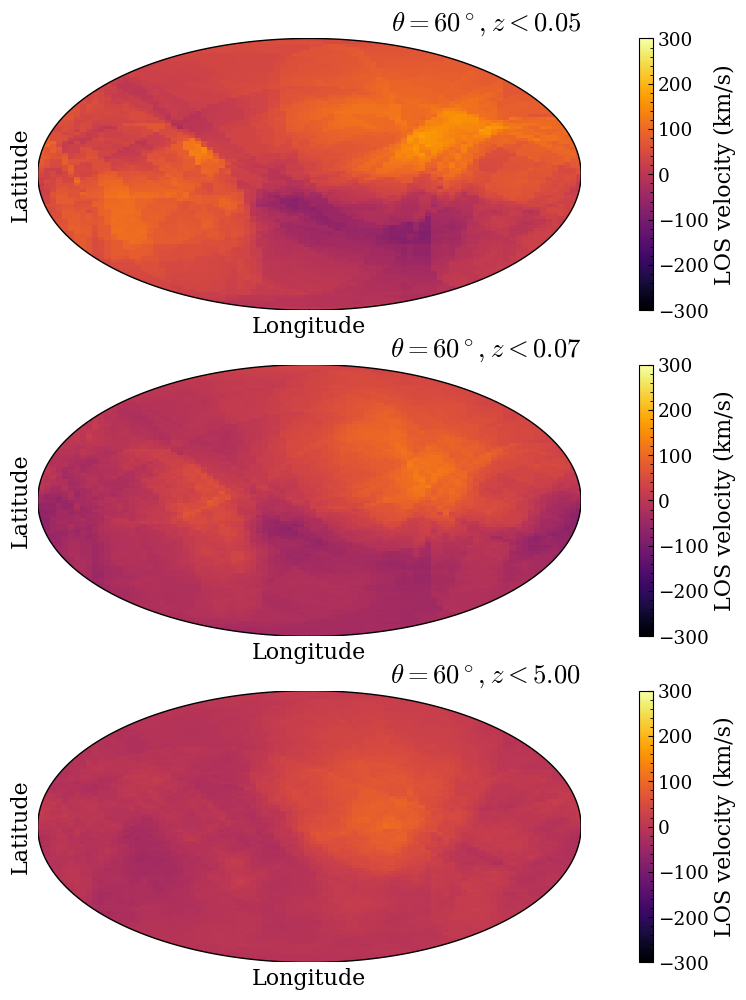

In [64]:
import sys
sys.path.append('../tools/')
import clusterplot as cp
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
# Use hammer projection
m = Basemap(projection='hammer', lon_0=0)

cone_size = 60
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Only 313 highest Lcore/Ltot clusters
data = data[:n_clusters]

redshift = data['ObservedRedshift']
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
for zmax, ax in zip([0.05, 0.07, 5], axes):
    # Select redshift range
    zmask = (redshift < zmax)
    
    # Calculate los velocity map
    _,_,los_v_map = main(data, zmask)
    
    # Plot the map
    cp._sky_map_(los_v_map, colorbar_label='LOS velocity (km/s)', ax=ax, vmin=-300, vmax=300)

    # Set the title
    ax.set_title(f'$\\theta={cone_size}^\\circ, z<{zmax:.2f}$', loc='right')

    # # Highlight some directions
    # m.scatter(51.49, 13.34, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)
    # m.scatter(50.17, 19.97, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)

plt.show()

## Summing all the clusters

In [57]:
import astropy.coordinates as coord
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Consider only our small samples?
data = data[:n_clusters]

redshift = data['ObservedRedshift']
print(redshift.min(), redshift.max())

# Peculiar los velocity
vx = np.array(data['Vx'])                 # velocities in km/s
vy = np.array(data['Vy'])
vz = np.array(data['Vz'])

x = np.array(data['x_lc'])
y = np.array(data['y_lc'])
z = np.array(data['z_lc'])

los_v = (vx*x + vy*y + vz*z) / (x**2 + y**2 + z**2)**0.5 # in km/s
los_v = np.array(los_v)

v_vecs = los_v[...,None] * np.column_stack([x,y,z]) / (x[...,None]**2 + y[...,None]**2 + z[...,None]**2)**0.5


for zmax in np.arange(0.03, redshift.max()+0.01, 0.02):
    zmask = (redshift < zmax)

    # Mask and sum
    bulk_v = np.sum(v_vecs[zmask,:], axis=0)/np.sum(zmask)
    r, b, l = coord.cartesian_to_spherical(bulk_v[0], bulk_v[1], bulk_v[2]) # r, lat, lon
    print(f"z<{zmax:.2f}, {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")

0.0106927399700134 0.1682769161224142
z<0.03, 50.52 km/s (153.31, 11.05)
z<0.05, 23.30 km/s (151.87, 65.88)
z<0.07, 32.19 km/s (52.66, 52.68)
z<0.09, 39.24 km/s (60.89, 43.65)
z<0.11, 38.65 km/s (57.35, 47.49)
z<0.13, 25.49 km/s (46.30, 32.08)
z<0.15, 23.43 km/s (42.82, 23.94)
z<0.17, 20.34 km/s (50.17, 19.97)


In [68]:
np.max((v_vecs[:,0]**2 + v_vecs[:,1]**2 + v_vecs[:,2]**2)**0.5)

1468.4738951765162

## Summing the scanned results

In [69]:
cone_size = 60
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Only 313 highest Lcore/Ltot clusters
data = data[:n_clusters]

redshift = data['ObservedRedshift']
for zmax in np.arange(0.03, redshift.max()+0.01, 0.02):
    zmask = (redshift < zmax)
    Glon, Glat, los_v_map = main(data, zmask)
    bulk_vx = np.sum(los_v_map * np.cos(Glat * np.pi / 180) * np.cos(Glon * np.pi / 180)) /len(los_v_map)
    bulk_vy = np.sum(los_v_map * np.cos(Glat * np.pi / 180) * np.sin(Glon * np.pi / 180)) /len(los_v_map)
    bulk_vz = np.sum(los_v_map * np.sin(Glat * np.pi / 180)) / len(los_v_map)
    r, b, l = coord.cartesian_to_spherical(bulk_vx, bulk_vy, bulk_vz) # r, lat, lon
    print(f"z<{zmax:.2f}, {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")
    #print(Glon[los_v_map.argmax()], Glat[los_v_map.argmax()], los_v_map.max())
    

z<0.03, 21.29 km/s (140.51, 29.85)
z<0.05, 15.17 km/s (173.64, 72.07)
z<0.07, 18.82 km/s (50.26, 63.59)
z<0.09, 22.92 km/s (61.99, 54.77)
z<0.11, 22.84 km/s (58.19, 58.03)
z<0.13, 13.56 km/s (47.11, 40.75)
z<0.15, 11.76 km/s (42.56, 29.01)
z<0.17, 9.97 km/s (50.32, 23.65)
